In [1]:
import numpy as np
from sklearn.datasets import make_moons
import math
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from matplotlib import cm
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
# !pip install hdfdict
import hdfdict
from prettytable import PrettyTable
from tqdm import tqdm,trange
import time
import sys

In [2]:

# Data Preparation --- MNIST
(X_train_orig, Y_train_orig), (X_test_orig, Y_test_orig) = mnist.load_data()

# Preparing the data
Y_tr_resh = Y_train_orig.reshape(60000, 1)
Y_te_resh = Y_test_orig.reshape(10000, 1)
Y_tr_T = to_categorical(Y_tr_resh, num_classes=10)
Y_te_T = to_categorical(Y_te_resh, num_classes=10)
y_tr = Y_tr_T.T
y_te = Y_te_T.T


# Flattening of inputs
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T

# Preprocessing of Inputs
X_tr = X_train_flatten.T / 255.
X_te = X_test_flatten.T / 255.
num_classes = y_tr.shape[0]
m_tr = X_tr.shape[0]
m_te = X_te.shape[0]


In [3]:
class Relu:
  def forward(self):
    return np.maximum(0,self)
  
  def backward(self):
    self[self<=0] = 0
    self[self>0] = 1
    return self

class Tanh:
  def forward(self):
    return np.tanh(self)

  def backward(self):
    return (1 - np.square(Tanh.forward(self)))

class Sigmoid:
  def forward(self):
    return (1 / (1 + np.exp(-self)))
  
  def backward(self):
    return (Sigmoid.forward(self)*(1-Sigmoid.forward(self)))

class Softmax:
  def forward(self):
    soft = np.exp(self)/np.sum(np.exp(self),axis=0)
    return soft

  def backward(self):
    return (Softmax.forward(self)*(1 - Softmax.forward(self))) 

class Sine:
  def forward(self):
    return np.sin(self)
  
  def backward(self):
    return np.cos(self)

In [4]:
class Predict:
  def __init__(self,A,threshold=0.5):
    self.A = A
    self.threshold = threshold
  def __call__(self):
    predictions = np.zeros((self.A.shape))
    for g in range(0,self.A.shape[1]):
      if self.A[:,g] >= self.threshold:
        predictions[:,g] = 1
    return predictions

class PredictMulti:
  def __init__(self,A):
    self.A = A
  def __call__(self):
    predictions_multi = np.zeros(self.A.shape)
    for v in range(0,self.A.shape[1]):
      temp = max(self.A[:,v])
      for w in range(0,self.A.shape[0]):
        if self.A[w,v] == temp:
          predictions_multi[w,v] = 1
        else:
          predictions_multi[w,v] = 0
    return predictions_multi

class Evaluate:
  def __init__(self,y,preds):
    self.y,self.preds = y,preds
  def __call__(self):
    accuracy = float(np.mean(self.preds==self.y,axis=1)*100)
    return accuracy

class EvaluateMulti:
  def __init__(self,y,preds):
    self.y,self.preds = y,preds
  def __call__(self):
    ones_array = np.ones(self.preds.shape)
    temp1 = self.preds==ones_array
    ind = []
    for gee in range(0,temp1.shape[1]):
      for jee in range(0,temp1.shape[0]):
        if temp1[jee,gee] == True:
          ind.append(jee)
    ind_arr = np.array(ind)
    y_list = []
    for gee in range(0,self.y.shape[1]):
      for jee in range(0,self.y.shape[0]):
        if self.y[jee,gee] == 1:
          y_list.append(jee)
    y_arr = np.array(y_list)
    accuracy = float(np.mean(ind_arr == y_arr.T))*100
    return accuracy


class PrecisionRecall:
  def __init__(self,A,y):
    self.A,self.y = A,y
  def __call__(self):
    tp = 0
    fp = 0
    fn = 0
    for i in range(0,self.y.shape[1]):
      if ((self.A[0,i]==1)and(self.y[0,i]==1)):
        tp = tp+1
      if ((self.A[0,i]==1)and(self.y[0,i]==0)):
        fp = fp+1
      if (self.A[0,i]==0)and(self.y[0,i]==1):
        fn = fn+1
    prec = tp/(tp+fp)
    rec = tp/(tp+fn)
    f1 = (2*prec*rec)/(prec+rec)
    return prec,rec,f1

class PrecisionRecallMulti:
  def __init__(self,A,y):
    self.A,self.y = A,y
  def __call__(self):
    epsilon = 1e-5
    tp_multi = {}
    fp_multi = {}
    fn_multi = {}
    prec_multi = {}
    rec_multi = {}
    f1_multi = {}
    num_classes = self.y.shape[0]
    for r in range(0,num_classes):
      tp_multi["class" + str(r)] = 0
      fp_multi["class" + str(r)] = 0
      fn_multi["class" + str(r)] = 0
    for c in range(0,self.y.shape[1]):
      for g in range(0,self.y.shape[0]):
        if ((self.A[g,c]==1) and (self.y[g,c]==1)):
          tp_multi["class" + str(g)] = tp_multi["class" + str(g)] + 1
        if ((self.A[g,c]==1) and (self.y[g,c]==0)):
          fp_multi["class" + str(g)] = fp_multi["class" + str(g)] + 1
        if ((self.A[g,c]==0) and (self.y[g,c]==1)):
          fn_multi["class" + str(g)] = fn_multi["class" + str(g)] + 1
    for n in range(0,num_classes):
      prec_multi["class" + str(n)] = tp_multi["class" + str(n)] / (tp_multi["class" + str(n)] + fp_multi["class" + str(n)] + epsilon)
      rec_multi["class" + str(n)] = tp_multi["class" + str(n)] / (tp_multi["class" + str(n)] + fn_multi["class" + str(n)] + epsilon)
      f1_multi["class" + str(n)] = (2*prec_multi["class" + str(n)]*rec_multi["class" + str(n)])/(prec_multi["class" + str(n)] + rec_multi["class" + str(n)] + epsilon)
    return prec_multi,rec_multi,f1_multi

class GradL1Reg:
  def __init__(self,layers_arr):
    self.layers_arr = layers_arr
  def __call__(self):
    for layer in self.layers_arr:
      layer.grad_L1 = np.zeros(layer.weights.shape)
      for p in range(0,layer.weights.shape[0]):
        for n in range(0,layer.weights.shape[1]):
          if layer.weights[p,n] > 0:
            layer.grad_L1[p,n] = 1
          else:
            layer.grad_L1[p,n] = -1

class CreateMiniBatches:
  def __init__(self,X,y,mb_size):
    self.X,self.y,self.mb_size = X,y,mb_size
  def __call__(self):
    m_ex = self.y.shape[1]
    mini_batch = {}
    num = m_ex//self.mb_size
    if (m_ex%self.mb_size != 0):
      f = 0
      for p in range(0,num):
        mini_batch["MB_X" + str(p)] = self.X[f:(f+self.mb_size),:]
        mini_batch["MB_Y" + str(p)] = self.y[:,f:(f+self.mb_size)]
        f = f + self.mb_size
      mini_batch["MB_X" + str(num)] = self.X[f:m_ex,:]
      mini_batch["MB_Y" + str(num)] = self.y[:,f:m_ex]
      return mini_batch,num
    else:
      f = 0
      for p in range(0,num-1):
        mini_batch["MB_X" + str(p)] = self.X[f:(f+self.mb_size),:]
        mini_batch["MB_Y" + str(p)] = self.y[:,f:(f+self.mb_size)]
        f = f + self.mb_size
      mini_batch["MB_X" + str(num-1)] = self.X[f:m_ex,:]
      mini_batch["MB_Y" + str(num-1)] = self.y[:,f:m_ex]
      return mini_batch,num-1


In [5]:
class StaticPlotHelpers:
  def __init__(self,costs_tr,costs_cv,accu_tr_arr,accu_cv_arr):
    self.costs_tr,self.costs_cv = costs_tr,costs_cv
    self.accu_tr_arr,self.accu_cv_arr = accu_tr_arr,accu_cv_arr

class AnimatePlotHelpers:
  def __init__(self,x_ax,y_ax,X_lab,Y_lab,plot_title,leg,loca,plot_col,direc,freq):
    self.x_ax,self.y_ax,self.X_lab,self.Y_lab = x_ax,y_ax,X_lab,Y_lab
    self.plot_title,self.leg,self.loca,self.plot_col,self.direc,self.freq = plot_title,leg,loca,plot_col,direc,freq


class PlotCostStatic(StaticPlotHelpers):
  def __init__(self,costs_tr,costs_cv,accu_tr_arr,accu_cv_arr):
    StaticPlotHelpers.__init__(self,costs_tr,costs_cv,accu_tr_arr,accu_cv_arr)
  def __call__(self):
    itera = np.arange(1,len(self.costs_tr)+1,1)
    plt.xlabel('Number of Iterations')
    plt.ylabel('Cost')
    plt.title('Cost Function Variation')
    plt.plot(itera,self.costs_tr,color='c',linewidth=2)
    if len(self.costs_cv) != 0:
      plt.plot(itera,self.costs_cv,color='#9ef705',linewidth=2)
    plt.legend(["Train","Cross Val"],loc='upper right')

class PlotTrCvStatic(StaticPlotHelpers):
  def __init__(self,costs_tr,costs_cv,accu_tr_arr,accu_cv_arr):
    StaticPlotHelpers.__init__(self,costs_tr,costs_cv,accu_tr_arr,accu_cv_arr)
  def __call__(self):
    itera = np.arange(1,len(self.costs_tr)+1,1)
    plt.xlabel('Number of Iterations')
    plt.ylabel('Accuracy')
    plt.title('Train - Cross Val Accuracy Curve')
    plt.plot(itera,self.accu_tr_arr,color='m',linewidth=2)
    if len(self.accu_cv_arr) != 0:
      plt.plot(itera,self.accu_cv_arr,color='r',linewidth=2)
    plt.legend(["Train","Cross Val"],loc='lower right')

class AnimatePlot(AnimatePlotHelpers):
  def __init__(self,x_ax,y_ax,X_lab,Y_lab,plot_title,leg,loca,plot_col,direc,freq):
    AnimatePlotHelpers.__init__(self,x_ax,y_ax,X_lab,Y_lab,plot_title,leg,loca,plot_col,direc,freq)
  def __call__(self):
    y_vals = self.y_ax
    x_vals = self.x_ax
    l = 0
    for k in range(1,len(x_vals)+1):
      plt.xlabel(self.X_lab)
      plt.ylabel(self.Y_lab)
      plt.title(self.plot_title)
      plt.legend([self.leg],loc=self.loca)
      plt.plot(x_vals[0:l],y_vals[0:l],color=self.plot_col)
      l = l+1
      if k%self.freq==0:
        plt.savefig(self.direc + 'plot{}.png'.format(k//self.freq))
    return

class AnimatePlotMulti(AnimatePlotHelpers):
  def __init__(self,x_ax,y_ax,X_lab,Y_lab,plot_title,leg,loca,plot_col,direc,freq):
    AnimatePlotHelpers.__init__(self,x_ax,y_ax,X_lab,Y_lab,plot_title,leg,loca,plot_col,direc,freq)
  def __call__(self):
    x_vals = {}
    y_vals = {}
    for m in range(0,len(self.x_ax)):
      x_vals["X" + str(m)] = self.x_ax[m]
    for g in range(0,len(self.y_ax)):
      y_vals["Y" + str(g)] = self.y_ax[g]
    for h in range(0,len(self.leg)):
      plt.plot([],[],color=self.plot_col[h],label = self.leg[h])
    plt.legend(loc=self.loca)
    l = 0
    for k in range(1,len(self.x_ax[0])+1):
      plt.xlabel(self.X_lab)
      plt.ylabel(self.Y_lab)
      plt.title(self.plot_title)
      for d in range(0,len(self.x_ax)):
        if len(x_vals["X" + str(d)]) != 0:
          plt.plot(x_vals["X" + str(d)][0:l],y_vals["Y" + str(d)][0:l],color=self.plot_col[d])
      l = l+1
      if k%self.freq==0:
        plt.savefig(self.direc + 'plot{}.png'.format(k//self.freq))
    return


In [6]:
class RegularizationHelpers:
  def __init__(self,layers_arr,lamb,m_exam):
    self.layers_arr,self.lamb,self.m_exam = layers_arr,lamb,m_exam


class L1Reg(RegularizationHelpers):
  def __init__(self,layers_arr,lamb,m_exam):
    RegularizationHelpers.__init__(self,layers_arr,lamb,m_exam)
  def __call__(self):
    temp_sum = 0
    for layers in self.layers_arr:
      temp_sum = temp_sum + ((self.lamb/self.m_exam)*(np.sum(np.sum(layers.weights))))
      layers.grad_reg = ((self.lamb/self.m_exam)*(layers.grad_L1))
    return temp_sum

class L2Reg(RegularizationHelpers):
  def __init__(self,layers_arr,lamb,m_exam):
    RegularizationHelpers.__init__(self,layers_arr,lamb,m_exam)
  def __call__(self):
    temp_sum = 0
    for layers in self.layers_arr:
      temp_sum = temp_sum + ((self.lamb/(2*self.m_exam))*(np.sum(np.sum(np.square(layers.weights)))))
      layers.grad_reg = ((self.lamb/self.m_exam)*(layers.weights))
    return temp_sum

In [7]:
class CostFunctionHelpers:
  def __init__(self,y,A,layers_arr,lamb,reg=None):
    self.y,self.A,self.layers_arr,self.lamb,self.reg = y,A,layers_arr,lamb,reg


class BinaryCrossEntropy(CostFunctionHelpers):
  def __init__(self,y,A,layers_arr,lamb,reg=None):
    CostFunctionHelpers.__init__(self,y,A,layers_arr,lamb,reg=None)
  def __call__(self):
    if self.reg is not None:
      if self.reg is "L1":
        GradL1Reg(self.layers_arr)()
        temp_sum = L1Reg(self.layers_arr,self.lamb,self.y.shape[1])()
      if self.reg is "L2":
        temp_sum = L2Reg(self.layers_arr,self.lamb,self.y.shape[1])()
      cost = (-1/self.y.shape[1])*(np.sum(np.sum((self.y*np.log(self.A)) + ((1-self.y)*(np.log(1-self.A)))))) + temp_sum
      grad = (-1/self.y.shape[1])*((self.y/self.A)-((1-self.y)/(1-self.A)))
    else:
      cost = (-1/self.y.shape[1])*(np.sum(np.sum((self.y*np.log(self.A)) + ((1-self.y)*(np.log(1-self.A))))))
      grad = (-1/self.y.shape[1])*((self.y/self.A)-((1-self.y)/(1-self.A)))
      for layers in self.layers_arr:
        layers.grad_reg = 0
    return cost,grad

class CrossEntropy(CostFunctionHelpers):
  def __init__(self,y,A,layers_arr,lamb,reg=None):
    CostFunctionHelpers.__init__(self,y,A,layers_arr,lamb,reg=None)
  def __call__(self):
    if self.reg is not None:
      if self.reg is "L1":
        GradL1Reg(self.layers_arr)()
        temp_sum = L1Reg(self.layers_arr,self.lamb,self.y.shape[1])()
      if self.reg is "L2":
        temp_sum = L2Reg(self.layers_arr,self.lamb,self.y.shape[1])()
      cost = (-1/self.y.shape[1])*(np.sum(np.sum((self.y*np.log(self.A)))))
      grad = (-1/self.y.shape[1])*((self.y/self.A))
    else:
      cost = (-1/self.y.shape[1])*(np.sum(np.sum((self.y*np.log(self.A)))))
      grad = (-1/self.y.shape[1])*((self.y/self.A))
      for layers in self.layers_arr:
        layers.grad_reg = 0
    return cost,grad


In [8]:
class Dense:
  """
      This layer is used for implemetation of Fully Connected Neural Networks
      Methods:
        Parameters Initialization
        Forward Propagation
        Backward Propagation
  """
  def __init__(self,num_inputs,num_outputs,activation_fn,dropout=1.0,weights=None,bias=None,dZ=None,dW=None,db=None,dA=None,grad_L1=None,grad_reg=None):
    self.num_inputs = num_inputs
    self.num_outputs = num_outputs
    self.activation_fn = activation_fn
    self.dropout = dropout
    self.dZ,self.dW,self.db,self.dA = dZ,dW,db,dA
    self.grad_L1 = grad_L1
    self.grad_reg = grad_reg
    self.weights = weights
    self.bias = bias
    self.activ_dict = {"relu":[Relu.forward,Relu.backward,2],
                       "tanh":[Tanh.forward,Tanh.backward,1],
                       "sigmoid":[Sigmoid.forward,Sigmoid.backward,1],
                       "softmax":[Softmax.forward,Softmax.backward,1],
                       "sine":[Sine.forward,Sine.backward,6]}

  def initialize_params(self):
    self.weights = np.random.randn(self.num_outputs,self.num_inputs)*(np.sqrt(self.activ_dict[self.activation_fn][2]/self.num_inputs))
    self.bias = np.random.randn(self.num_outputs, 1)*0.01
    return self.weights,self.bias,self.grad_reg,self.grad_L1

  def get_params(self):
    return self.weights, self.bias
    
  def forw_prop(self,A_prev,train=True):
    if train is False:
      self.dropout = 1
    self.outputs = np.dot(self.weights,A_prev) + self.bias
    self.activations_temp = self.activ_dict[self.activation_fn][0](self.outputs)
    self.activations = self.activations_temp*((np.random.rand(self.outputs.shape[0],self.outputs.shape[1]) < self.dropout)/self.dropout)
    return self.outputs,self.activations

  def back_prop(self,dA_prev,A_prev):
    self.dZ = dA_prev*self.activ_dict[self.activation_fn][1](self.outputs)
    self.dW = (np.dot(self.dZ,A_prev.T)) + self.grad_reg
    self.db = np.sum(self.dZ,axis=1,keepdims = True)
    self.dA = np.dot(self.weights.T,self.dZ)
    return self.dZ,self.dW,self.db,self.dA

In [9]:
class OptimizerHelpers:
  def __init__(self,alpha,layers_arr,V_dict,S_dict,t):
    self.alpha,self.layers_arr,self.V_dict,self.S_dict,self.t = alpha,layers_arr,V_dict,S_dict,t


class GradientDescent(OptimizerHelpers):
  def __init__(self,alpha,layers_arr,V_dict,S_dict,t):
    OptimizerHelpers.__init__(self,alpha,layers_arr,V_dict,S_dict,t)
  def __call__(self):
    for layers in self.layers_arr:
      layers.weights -= (self.alpha*layers.dW)
      layers.bias -= (self.alpha*layers.db)

class Momentum(OptimizerHelpers):
  def __init__(self,alpha,layers_arr,V_dict,S_dict,t):
    OptimizerHelpers.__init__(self,alpha,layers_arr,V_dict,S_dict,t)
  def __call__(self):
    beta1 = 0.9
    for h in range(1,len(self.layers_arr)+1):
      self.V_dict["Vdw" + str(h)] = (beta1*self.V_dict["Vdw" + str(h)]) + ((1-beta1)*self.layers_arr[h-1].dW)
      self.V_dict["Vdb" + str(h)] = (beta1*self.V_dict["Vdb" + str(h)]) + ((1-beta1)*self.layers_arr[h-1].db)
    for g in range(1,len(self.layers_arr)+1):
      self.layers_arr[g-1].weights -= (self.alpha*self.V_dict["Vdw" + str(g)])
      self.layers_arr[g-1].bias -= (self.alpha*self.V_dict["Vdb" + str(g)])

class RMSProp(OptimizerHelpers):
  def __init__(self,alpha,layers_arr,V_dict,S_dict,t):
    OptimizerHelpers.__init__(self,alpha,layers_arr,V_dict,S_dict,t)
  def __call__(self):
    beta2 = 0.999
    epsilon = 1e-8
    for h in range(1,len(self.layers_arr)+1):
      self.S_dict["Sdw" + str(h)] = (beta2*self.S_dict["Sdw" + str(h)]) + ((1-beta2)*np.square(self.layers_arr[h-1].dW))
      self.S_dict["Sdb" + str(h)] = (beta2*self.S_dict["Sdb" + str(h)]) + ((1-beta2)*np.square(self.layers_arr[h-1].db))
    for g in range(1,len(self.layers_arr)+1):
      self.layers_arr[g-1].weights -= ((self.alpha*self.layers_arr[g-1].dW)/(np.sqrt(self.S_dict["Sdw" + str(g)]) + epsilon))
      self.layers_arr[g-1].bias -= ((self.alpha*self.layers_arr[g-1].db)/(np.sqrt(self.S_dict["Sdb" + str(g)]) + epsilon))

class Adam(OptimizerHelpers):
  def __init__(self,alpha,layers_arr,V_dict,S_dict,t):
    OptimizerHelpers.__init__(self,alpha,layers_arr,V_dict,S_dict,t)
  def __call__(self):
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8
    S_dict_corr = {}
    V_dict_corr = {}
    for h in range(1,len(self.layers_arr)+1):
      self.V_dict["Vdw" + str(h)] = (beta1*self.V_dict["Vdw" + str(h)]) + ((1-beta1)*self.layers_arr[h-1].dW)
      self.V_dict["Vdb" + str(h)] = (beta1*self.V_dict["Vdb" + str(h)]) + ((1-beta1)*self.layers_arr[h-1].db)
    for u in range(1,len(self.layers_arr)+1):
      self.S_dict["Sdw" + str(u)] = (beta2*self.S_dict["Sdw" + str(u)]) + ((1-beta2)*np.square(self.layers_arr[u-1].dW))
      self.S_dict["Sdb" + str(u)] = (beta2*self.S_dict["Sdb" + str(u)]) + ((1-beta2)*np.square(self.layers_arr[u-1].db))
    for n in range(1,len(self.layers_arr)+1):
      S_dict_corr["Sdw" + str(n)] = self.S_dict["Sdw" + str(n)]/(1 - np.power(beta2,self.t))
      S_dict_corr["Sdb" + str(n)] = self.S_dict["Sdb" + str(n)]/(1 - np.power(beta2,self.t))
      V_dict_corr["Vdw" + str(n)] = self.V_dict["Vdw" + str(n)]/(1 - np.power(beta1,self.t))
      V_dict_corr["Vdb" + str(n)] = self.V_dict["Vdb" + str(n)]/(1 - np.power(beta1,self.t))
    for g in range(1,len(self.layers_arr)+1):
      self.layers_arr[g-1].weights -= ((self.alpha*V_dict_corr["Vdw" + str(g)])/(np.sqrt(S_dict_corr["Sdw" + str(g)]) + epsilon))
      self.layers_arr[g-1].bias -= ((self.alpha*V_dict_corr["Vdb" + str(g)])/(np.sqrt(S_dict_corr["Sdb" + str(g)]) + epsilon))


In [10]:
class Model:
  """
      Binds all the other classes together and contains methods for adding layers,
      training the network and testing the network
      Methods:
        Add
        Fit
        Test
  """ 
  def __init__(self,X_tr,y_tr,X_te,y_te,X_cv,y_cv):
    self.X_tr, self.y_tr = X_tr, y_tr
    self.X_te, self.y_te = X_te, y_te
    self.X_cv, self.y_cv = X_cv, y_cv
    self.layer_names = []
    self.layer_names_arr = []
    self.activations_cache = None
    self.params = None
    self.arch = {}
    self.accu_tr_arr = None
    self.cost_tr_arr = None
    self.accu_cv_arr = None
    self.cost_cv_arr = None
    self.lr = None
    self.epochs = None

  def add(self,layer_name,num_inputs,num_outputs,act_fn,dropout=1):
    self.layer_names_arr.append(layer_name)
    self.arch[str(layer_name)] = [layer_name.encode('utf8'),num_inputs,num_outputs,act_fn.encode('utf8'),dropout]
    layer_name = Dense(num_inputs,num_outputs,act_fn,dropout)
    Dense.initialize_params(layer_name)
    self.layer_names.append(layer_name)
  
  def reset(self):
    self.layer_names = []
    self.arch = {}
    self.layer_names_arr = []
    return self.layer_names,self.arch,self.layer_names_arr

  def params_dict(self,print_params):
    self.params = {}
    hee = 1
    for layer in self.layer_names:
      self.params["W" + str(hee)],self.params["b" + str(hee)] = Dense.get_params(layer)
      hee += 1
    if print_params is True:
      print(self.params)
      return self.params
    else:
      return self.params

  def forward_prop(self,X,train_model=True):
    self.activations_cache = {}
    self.activations_cache = {"A0":X.T}
    temp_A = X.T
    p = 1
    for layer in self.layer_names:
      _,temp_A = Dense.forw_prop(layer,temp_A,train_model)
      self.activations_cache["A" + str(p)] = temp_A
      p += 1
    return self.activations_cache

  def backward_prop(self,y,prob_type,activations_cache,lamb,reg):
    prob_type_dict = {"Binary":[BinaryCrossEntropy,PrecisionRecall,Predict,Evaluate],
                      "Multi":[CrossEntropy,PrecisionRecallMulti,PredictMulti,EvaluateMulti]}
    _,temp_dA = prob_type_dict[prob_type][0](y,activations_cache["A" + str(len(self.layer_names))],self.layer_names,lamb,reg)()
    l = 1
    for layer in reversed(self.layer_names):
      _,layer.dW,layer.db,temp_dA = Dense.back_prop(layer,temp_dA,self.activations_cache["A" + str(len(self.layer_names)-l)])
      l += 1
  
  def fit(self,X,y,alpha,num_iter,optim,prob_type,mb,reg=None,lamb=None,alpha_decay=False,print_cost=True,callback=None):
    self.lr = alpha
    if (num_iter > 100) and (num_iter <= 1000):
      freq = 10
    elif num_iter > 1000:
      freq = 50
    elif (num_iter <= 100):
      freq = 1
    params = self.params_dict(print_params=False)
    V_dict = {}
    S_dict = {}
    mini_batches,num = CreateMiniBatches(X,y,mb)()
    self.accu_tr_arr = []
    self.cost_tr_arr = []
    self.accu_cv_arr = []
    self.cost_cv_arr = []
    for k in range(1,len(self.layer_names)+1):
      V_dict["Vdw" + str(k)] = np.zeros(params["W" + str(k)].shape)
      V_dict["Vdb" + str(k)] = np.zeros(params["b" + str(k)].shape)
      S_dict["Sdw" + str(k)] = np.zeros(params["W" + str(k)].shape)
      S_dict["Sdb" + str(k)] = np.zeros(params["b" + str(k)].shape)
    optim_dict = {"GD":[GradientDescent,None,None,0],
                  "Momentum":[Momentum,V_dict,None,0],
                  "RMSprop":[RMSProp,None,S_dict,0],
                  "Adam":[Adam,V_dict,S_dict,0]}
    prob_type_dict = {"Binary":[BinaryCrossEntropy,PrecisionRecall,Predict,Evaluate],
                      "Multi":[CrossEntropy,PrecisionRecallMulti,PredictMulti,EvaluateMulti]}

    for i in range(1,num_iter+1):
      params_plot = self.params_dict(print_params=False)
      if alpha_decay is True:
        alpha = (np.power(0.95,i))*self.lr
      for vee in tqdm(range(0,num+1),file=sys.stdout):
        activations_dict = self.forward_prop(mini_batches["MB_X" + str(vee)])
        self.backward_prop(mini_batches["MB_Y" + str(vee)],prob_type,activations_dict,lamb,reg)
        optim_dict[optim][0](alpha,self.layer_names,optim_dict[optim][1],optim_dict[optim][2],optim_dict[optim][3]+i)()
        time.sleep(0.005)
      act_tr = self.forward_prop(X)
      cost_tr,_ = prob_type_dict[prob_type][0](y,act_tr["A" + str(len(self.layer_names))],self.layer_names,lamb,reg)()
      preds = prob_type_dict[prob_type][2](act_tr["A" + str(len(self.layer_names))])()
      accu_tr = prob_type_dict[prob_type][3](y,preds)()
      self.accu_tr_arr.append(accu_tr)
      self.cost_tr_arr.append(cost_tr)
      if self.X_cv is not None:
        act_cv = self.forward_prop(self.X_cv)
        cost_cv,_ = prob_type_dict[prob_type][0](self.y_cv,act_cv["A" + str(len(self.layer_names))],self.layer_names,lamb,reg)()
        preds_cv = prob_type_dict[prob_type][2](act_cv["A" + str(len(self.layer_names))])()
        accu_cv = prob_type_dict[prob_type][3](self.y_cv,preds_cv)()
        self.accu_cv_arr.append(accu_cv)
        self.cost_cv_arr.append(cost_cv)
      if ((i%1==0) and print_cost==True):
        if self.X_cv is None:
          print("Iteration " + str(i) + " " + "train_cost: " + str(np.round(cost_tr,6)) + " --- " + "train_acc: " + str(np.round(accu_tr,3)))
        else:
          print("Iteration " + str(i) + " " + "train_cost: " + str(np.round(cost_tr,6)) + " --- " + "train_acc: " + str(np.round(accu_tr,3)) + " --- " + "val_cost: " + str(np.round(cost_cv,6)) + " --- " + "val_accu: " + str(np.round(accu_cv,3)))
      if (i % 1 == 0):
        if (callback is not None):
          callback(i, params_plot)

  def save_model(self,fname):
    params = self.params_dict(print_params=False)
    archi = self.arch
    model_dict = {"Parameters":params,"Architecture":archi}
    hdfdict.dump(model_dict,fname)
    print("Model saved!")

  def load_model(self,fname):
    print("Model loading....")
    model_dict = dict(hdfdict.load(fname))
    params_dict = model_dict["Parameters"]
    arch_dict = model_dict["Architecture"]
    self.reset()
    for key in arch_dict:
      self.add(arch_dict[key][0].decode('utf8'),int(arch_dict[key][1]),int(arch_dict[key][2]),arch_dict[key][3].decode('utf8'),int(arch_dict[key][4]))
    dee = 1
    for layer in self.layer_names:
      layer.weights = params_dict["W" + str(dee)]
      layer.bias = params_dict["b" + str(dee)]
      dee += 1
    print("Model loaded!")

  def plot(self,type_func,animate=False,direc=None):
    itera = np.arange(1,len(self.cost_tr_arr)+1)
    if (len(itera) > 100) and (len(itera) <= 1000):
      freq = 10
    elif len(itera) > 1000:
      freq = 50
    elif (len(itera) <= 100):
      freq = 1
    plot_dict = {"Cost":[PlotCostStatic,AnimatePlotMulti,self.cost_tr_arr,self.cost_cv_arr,'Costs','Train-Cross Val Costs Curve','upper right',['c','#9ef705'],AnimatePlot,"Costs","Cost Function Curve"],
                 "Accuracy":[PlotTrCvStatic,AnimatePlotMulti,self.accu_tr_arr,self.accu_cv_arr,'Accuracy','Train-Cross Val Accuracy Curve','lower right',['m','r'],AnimatePlot,"Accuracy","Accuracy Curve"]}
    if animate is False:
      plot_dict[type_func][0](self.cost_tr_arr,self.cost_cv_arr,self.accu_tr_arr,self.accu_cv_arr)()
    else:
      if len(self.cost_cv_arr) != 0:
        plot_dict[type_func][1]([itera,itera],[plot_dict[type_func][2],plot_dict[type_func][3]],'Number of Iterations',plot_dict[type_func][4],plot_dict[type_func][5],['Train', 'Cross Val'],plot_dict[type_func][6],plot_dict[type_func][7],direc,freq)()
      else:
        plot_dict[type_func][8](itera,plot_dict[type_func][2],"Number of Iterations",plot_dict[type_func][9],plot_dict[type_func][10],"Train",plot_dict[type_func][6],plot_dict[type_func][7][0],direc,freq)()
      print("Go to your directory to find the images! Feed them to a GIF creator to animate them!")


  def summary(self):
    tab = PrettyTable()
    tab.field_names = ["Layer Number","Layer Name","Inputs","Outputs","Activation","Dropout","Number of Parameters"]
    yee = 1
    total_params = 0
    for layer in self.layer_names:
      total_params += (layer.weights.shape[0]*layer.weights.shape[1])+len(layer.bias)
      tab.add_row([str(yee),self.layer_names_arr[yee-1],layer.weights.shape[1],layer.weights.shape[0],layer.activation_fn,layer.dropout,str((layer.weights.shape[0]*layer.weights.shape[1])+len(layer.bias))])
      yee += 1
    print(tab)
    print("Total number of trainable Parameters: " + str(total_params))

  def test(self,X,y,prob_type,training=False,print_values=True):
    prob_type_dict = {"Binary":[BinaryCrossEntropy,PrecisionRecall,Predict,Evaluate],
                      "Multi":[CrossEntropy,PrecisionRecallMulti,PredictMulti,EvaluateMulti]}
    act_te = self.forward_prop(X,training)
    predictions_te = prob_type_dict[prob_type][2](act_te["A" + str(len(self.layer_names))])()
    accu_te = prob_type_dict[prob_type][3](y,predictions_te)()
    prec_te,rec_te,f1_te = prob_type_dict[prob_type][1](predictions_te,y)()
    tab = PrettyTable()
    if prob_type == "Multi":
      tab.field_names = ["Class","Precision","Recall","F1"]
      for hee in range(0,y.shape[0]):
        tab.add_row([hee,prec_te["class" + str(hee)],rec_te["class" + str(hee)],f1_te["class" + str(hee)]])
      if print_values is True:
        print(tab)
        print("Test Accuracy: " + str(accu_te))
    if prob_type == "Binary":
      tab.field_names = ["Precision","Recall","F1"]
      tab.add_row([str(prec_te),str(rec_te),str(f1_te)])
      if print_values is True:
        print(tab)
        print("Test Accuracy: " + str(accu_te))
    if print_values is not True:
      return accu_te,prec_te,rec_te,f1_te

In [11]:
model = Model(X_tr,y_tr,X_te,y_te,None,None)

In [12]:
model.reset()
model.add("dense1",X_tr.shape[1],500,"relu")
model.add("dense2",500,250,"relu")
model.add("dense3",250,150,"relu")
model.add("dense4",150,100,"sine")
model.add("dense5",100,60,"sine")
model.add("dense6",60,30,"relu")
model.add("dense7",30,15,"tanh")
model.add("dense8",15,10,"softmax")

In [13]:
model.summary()

+--------------+------------+--------+---------+------------+---------+----------------------+
| Layer Number | Layer Name | Inputs | Outputs | Activation | Dropout | Number of Parameters |
+--------------+------------+--------+---------+------------+---------+----------------------+
|      1       |   dense1   |  784   |   500   |    relu    |    1    |        392500        |
|      2       |   dense2   |  500   |   250   |    relu    |    1    |        125250        |
|      3       |   dense3   |  250   |   150   |    relu    |    1    |        37650         |
|      4       |   dense4   |  150   |   100   |    sine    |    1    |        15100         |
|      5       |   dense5   |  100   |    60   |    sine    |    1    |         6060         |
|      6       |   dense6   |   60   |    30   |    relu    |    1    |         1830         |
|      7       |   dense7   |   30   |    15   |    tanh    |    1    |         465          |
|      8       |   dense8   |   15   |    10   |  

In [14]:
model.fit(X_tr,y_tr,0.0005,15,"Adam","Multi",mb=2048,alpha_decay=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  3.97it/s]
Iteration 1 train_cost: 1.072602 --- train_acc: 72.165
100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  3.96it/s]
Iteration 2 train_cost: 0.91128 --- train_acc: 75.287
100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  3.95it/s]
Iteration 3 train_cost: 0.811074 --- train_acc: 76.607
100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  3.97it/s]
Iteration 4 train_cost: 0.756508 --- train_acc: 77.337
100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  3.96it/s]
Iteration 5 train_cost: 0.717381 --- train_acc: 77.757
100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  3.86it/s]
Iterat

In [15]:
model.test(X_te,y_te,"Multi")

+-------+--------------------+----------------------+----------------------+
| Class |     Precision      |        Recall        |          F1          |
+-------+--------------------+----------------------+----------------------+
|   0   | 0.9738693369460368 |  0.9887755001145357  |  0.9812608131618308  |
|   1   | 0.9937832949042337 |  0.9859030750140698  |  0.9898225013001671  |
|   2   | 0.9299719801123064 |  0.9651162697178657  |  0.947213252366792   |
|   3   |  0.4904999975475   |  0.9712871190961672  |  0.6518227791124057  |
|   4   | 0.5105820078805184 |  0.9826883810316865  |  0.6720010661541121  |
|   5   | 0.9722222109696503 |  0.9417040253172195  |  0.9567148081684581  |
|   6   | 0.9850905113408891 |  0.9655532258292983  |  0.9752190282001273  |
|   7   | 0.9715686179257979 |  0.9640077727236598  |  0.9677684281512131  |
|   8   | 0.6249996093752441 | 0.010266940346335315 | 0.020201701790348758 |
|   9   | 0.8987340634513843 | 0.07036669900528544  | 0.13051335673616205  |

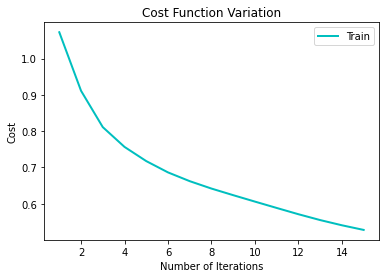

In [16]:
model.plot("Cost")

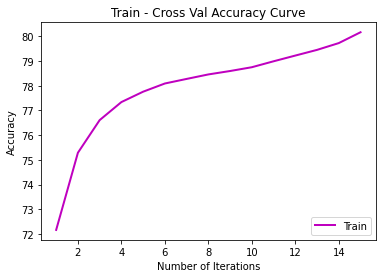

In [17]:
model.plot("Accuracy")

In [18]:
model.save_model('mnist.h5')

Model saved!


C:\Users\dungm\anaconda3\envs\nn\lib\site-packages\hdfdict\hdfdict.py:8: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  hdf = h5py.File(hdf)


In [19]:
model1 = Model(X_tr,y_tr,X_te,y_te,None,None)

In [20]:
model1.load_model('mnist.h5')

Model loading....
Model loaded!


C:\Users\dungm\anaconda3\envs\nn\lib\site-packages\hdfdict\hdfdict.py:36: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  d[k] = v.value


In [21]:
model1.summary()

+--------------+------------+--------+---------+------------+---------+----------------------+
| Layer Number | Layer Name | Inputs | Outputs | Activation | Dropout | Number of Parameters |
+--------------+------------+--------+---------+------------+---------+----------------------+
|      1       |   dense1   |  784   |   500   |    relu    |    1    |        392500        |
|      2       |   dense2   |  500   |   250   |    relu    |    1    |        125250        |
|      3       |   dense3   |  250   |   150   |    relu    |    1    |        37650         |
|      4       |   dense4   |  150   |   100   |    sine    |    1    |        15100         |
|      5       |   dense5   |  100   |    60   |    sine    |    1    |         6060         |
|      6       |   dense6   |   60   |    30   |    relu    |    1    |         1830         |
|      7       |   dense7   |   30   |    15   |    tanh    |    1    |         465          |
|      8       |   dense8   |   15   |    10   |  

In [22]:
model1.test(X_te,y_te,"Multi")

+-------+--------------------+----------------------+----------------------+
| Class |     Precision      |        Recall        |          F1          |
+-------+--------------------+----------------------+----------------------+
|   0   | 0.9738693369460368 |  0.9887755001145357  |  0.9812608131618308  |
|   1   | 0.9937832949042337 |  0.9859030750140698  |  0.9898225013001671  |
|   2   | 0.9299719801123064 |  0.9651162697178657  |  0.947213252366792   |
|   3   |  0.4904999975475   |  0.9712871190961672  |  0.6518227791124057  |
|   4   | 0.5105820078805184 |  0.9826883810316865  |  0.6720010661541121  |
|   5   | 0.9722222109696503 |  0.9417040253172195  |  0.9567148081684581  |
|   6   | 0.9850905113408891 |  0.9655532258292983  |  0.9752190282001273  |
|   7   | 0.9715686179257979 |  0.9640077727236598  |  0.9677684281512131  |
|   8   | 0.6249996093752441 | 0.010266940346335315 | 0.020201701790348758 |
|   9   | 0.8987340634513843 | 0.07036669900528544  | 0.13051335673616205  |

In [23]:
sns.set_style("whitegrid")
GRID_X_START = 2.5
GRID_X_END = -1.25
GRID_Y_START = 1.5
GRID_Y_END = -1
OUTPUT_DIR = "/content/drive/My Drive/Colab Notebooks/nn_visuals/moons1_foo"
grid = np.mgrid[GRID_X_START:GRID_X_END:100j,GRID_X_START:GRID_Y_END:100j]
grid_2d = grid.reshape(2,-1)
XX, YY = grid
def make_plot(X, y, plot_name, file_name=None, XX=None, YY=None, preds=None, dark=False):
    if (dark):
        plt.style.use('dark_background')
    else:
        sns.set_style("whitegrid")
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    if(XX is not None and YY is not None and preds is not None):
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha = 1, cmap=cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black')
    if(file_name):
        plt.savefig(file_name)
        plt.close()
import os
def callback_numpy_plot(index, init_params):
    plot_title = "Iteration {:05}".format(index)
    file_name = "numpy_model_{:05}.png".format(index//1)
    file_path = os.path.join(OUTPUT_DIR, file_name)
    act = model.forward_prop(np.transpose(grid_2d),train_model=False)
    prediction_probs = act["A" + str(len(model.layer_names))]
    prediction_probs = prediction_probs.reshape(prediction_probs.shape[1], 1)
    make_plot(X_te, y_te, plot_title, file_name=file_path, XX=XX, YY=YY, preds=prediction_probs, dark=True)

In [25]:
model.reset()
model.add("dense1",X_tr.shape[1],500,"relu")
model.add("dense2",500,250,"relu")
model.add("dense3",250,150,"relu")
model.add("dense4",150,100,"tanh")
model.add("dense5",100,60,"tanh")
model.add("dense6",60,30,"relu")
model.add("dense7",30,15,"tanh")
model.add("dense8",15,1,"sigmoid")



In [26]:
model.fit(X_tr,y_tr,0.005,35,"Adam","Binary",mb=y_tr.shape[1],alpha_decay=True,print_cost=False,callback=callback_numpy_plot)

  0%|                                                                                            | 0/1 [00:02<?, ?it/s]


ValueError: shapes (15,1) and (10,60000) not aligned: 1 (dim 1) != 10 (dim 0)

In [27]:
act = model.forward_prop(np.transpose(grid_2d),train_model=True)
prediction_probs_np = act["A" + str(len(model.layer_names))]
prediction_probs_np = prediction_probs_np.reshape(prediction_probs_np.shape[1], 1)
make_plot(X_te, y_te, "Final Iteration", file_name=None, XX=XX, YY=YY, preds=prediction_probs_np, dark=True)

ValueError: shapes (500,784) and (2,10000) not aligned: 784 (dim 1) != 2 (dim 0)

In [28]:
act_te = model1.forward_prop(X_te,False)
predictions_te = PredictMulti(act_te["A" + str(len(model1.layer_names))])()
ones_arr = np.ones(predictions_te.shape)
temp1 = predictions_te == ones_arr
ind = []
for gee in range(0, temp1.shape[1]):
    for jee in range(0, temp1.shape[0]):
        if temp1[jee, gee] == True:
            ind.append(jee)
ind_arr = np.array(ind)

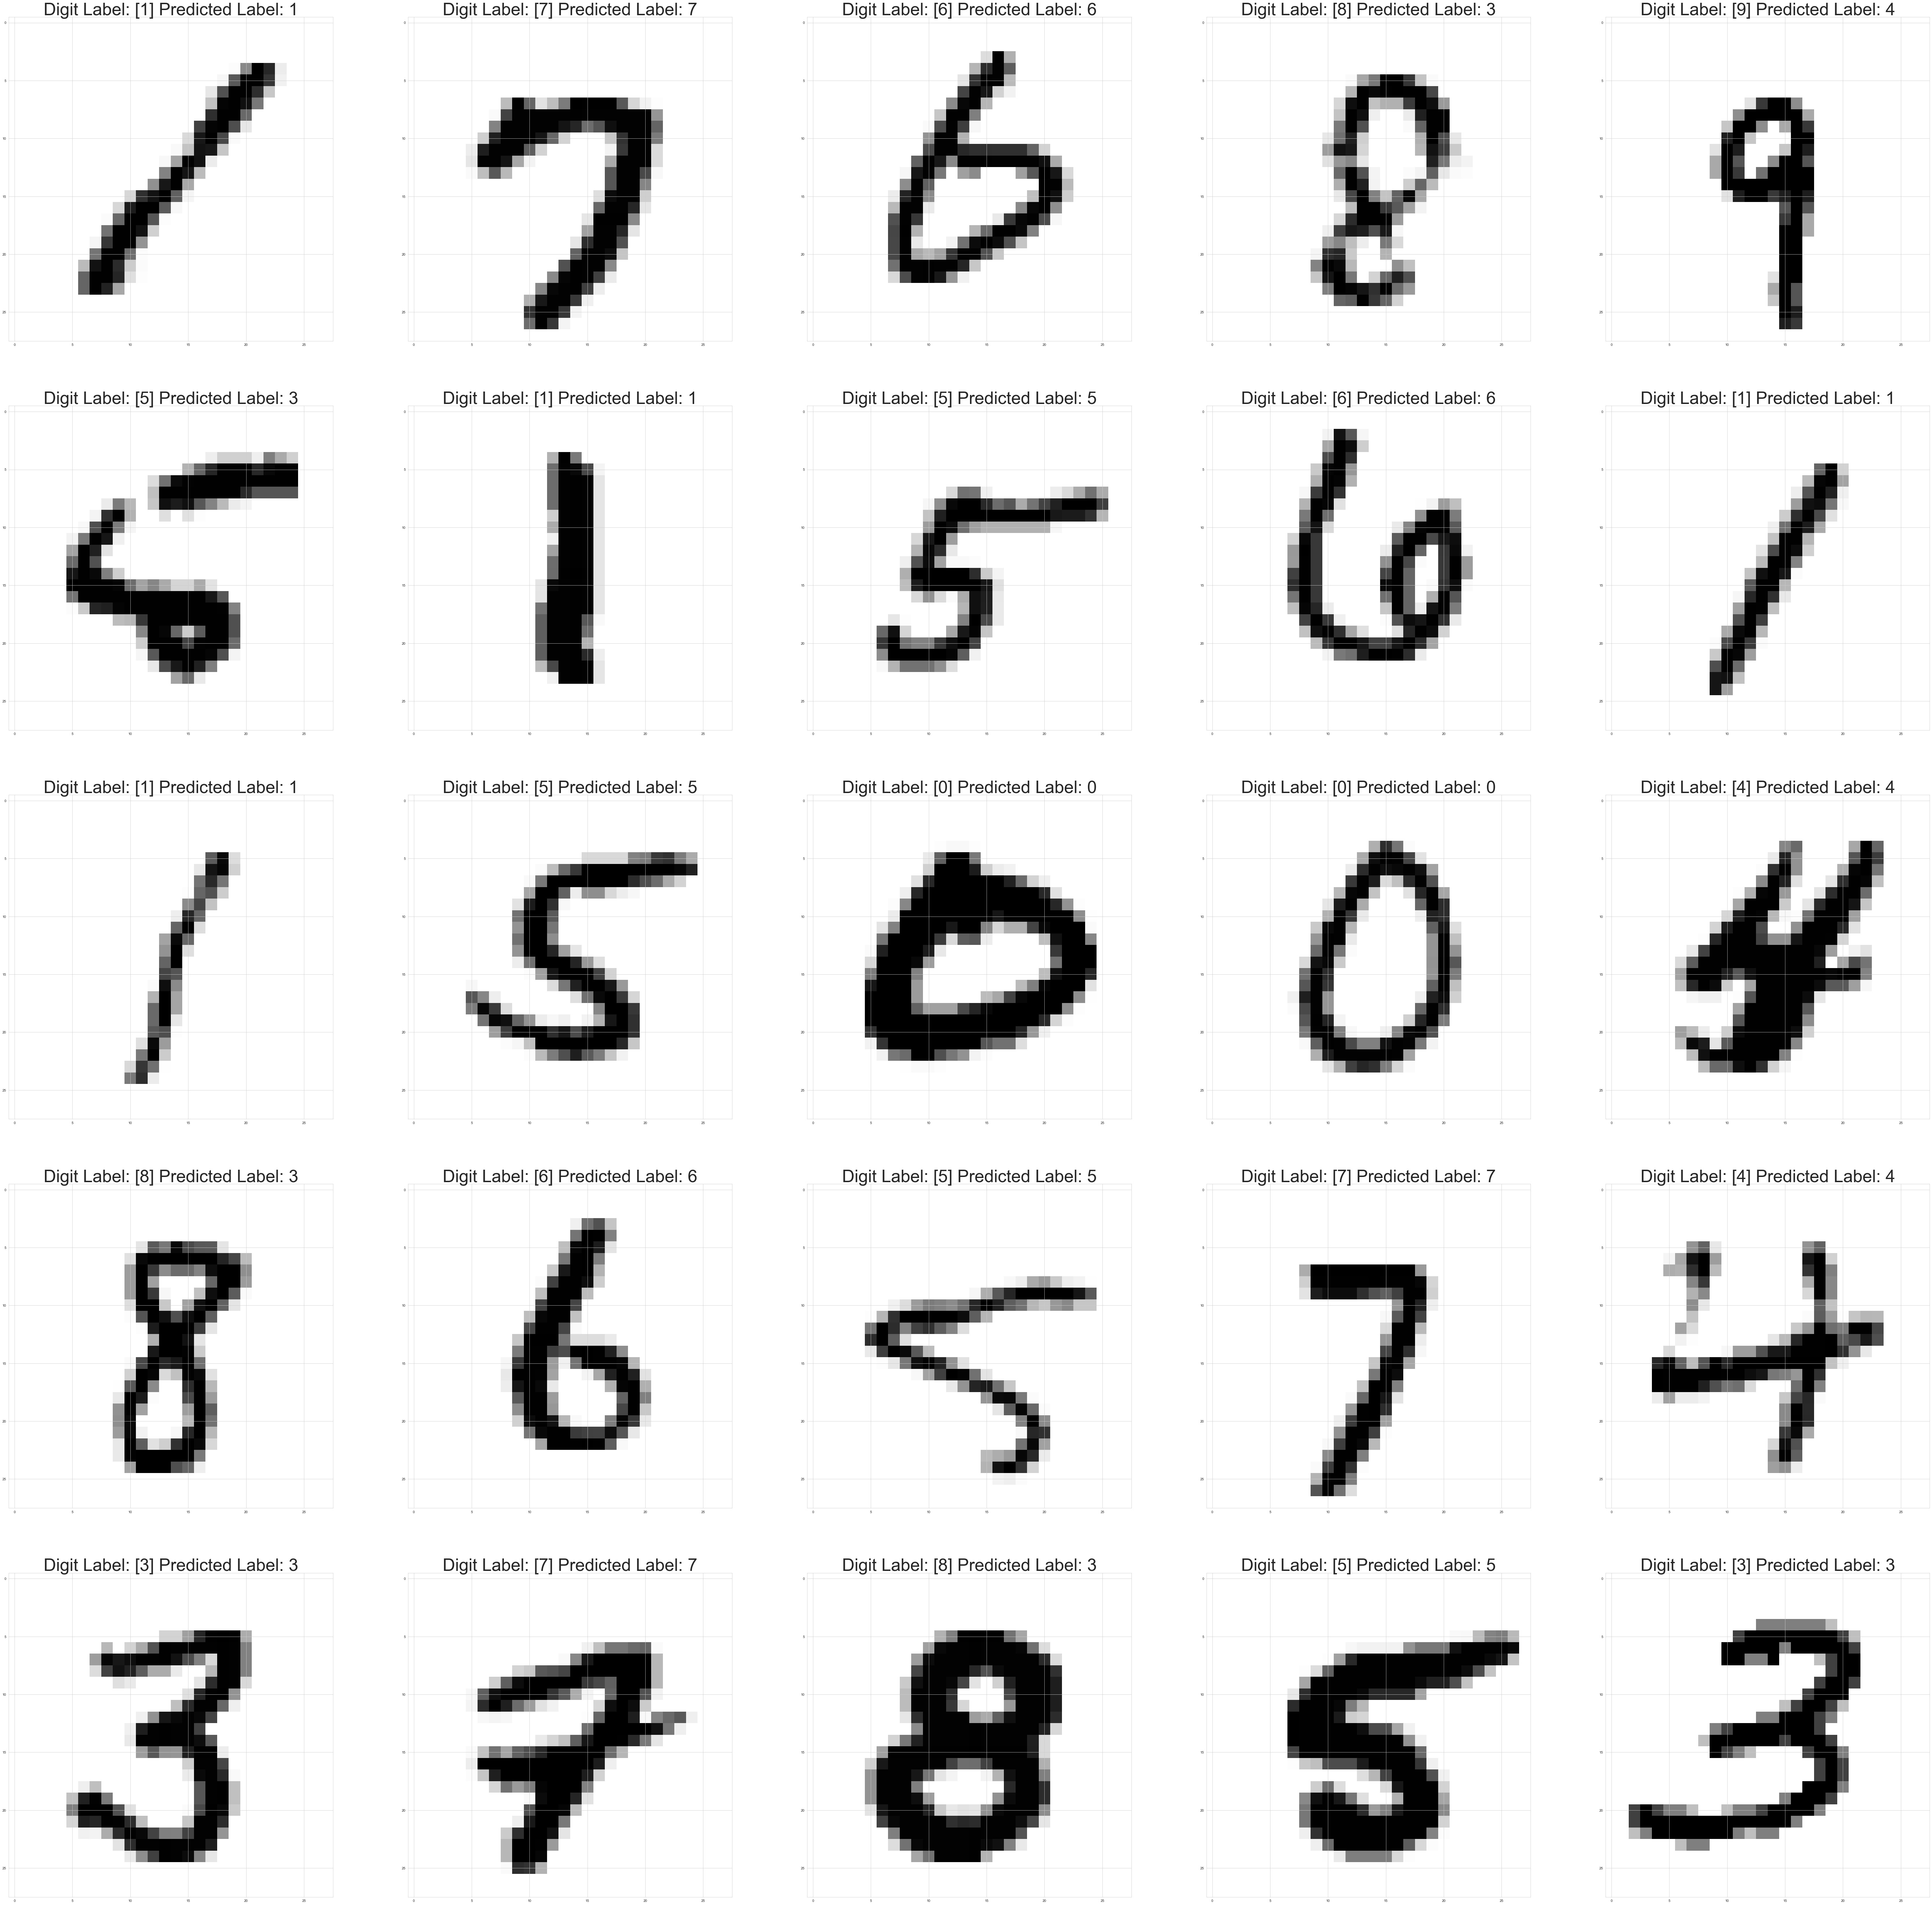

In [29]:
perm = np.random.permutation(9999)
l = 0

fig, axs = plt.subplots(5, 5, figsize=(100,100))

for g in range(0,5):
  for h in range(0,5):
    foo = perm[l]
    second_image = X_test_orig[foo, :]
    second_label = Y_te_resh[foo]
    second_pred_label = ind_arr[foo]
    axs[h,g].set_title('Digit Label: {} Predicted Label: {}'.format(second_label,second_pred_label),fontsize=50)
    axs[h,g].imshow(second_image,cmap='gray_r')
    l = l+1